In [1]:
import pandas as pd
#pd.set_option('display.max_rows', None)
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib import path
import os
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy
import numpy as np
import netCDF4 as nc
np.set_printoptions(threshold=100000)
from shapely.geometry import Polygon, Point, MultiPoint
from shapely.ops import cascaded_union
from datetime import datetime, timedelta
import time
import warnings
import statsmodels.api as sm
import datetime
import math
from scipy.ndimage.interpolation import shift

warnings.filterwarnings('ignore')
import seaborn as sns
from my_functions import sat_vap_press, vap_press, hot_dry_windy, haines

<AxesSubplot:>

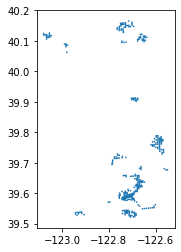

In [22]:
ac_mcclure = gpd.read_file("/data2/lthapa/ML_daily/August_Complex_2020/August_Complex_2020/VIIRS_perdetect_August_2020.shp")
ac_mcclure.plot() # TIME IS IN UTC

## Aggregate McClure Data by Max (to avoid double counting FRP) and Sum (to add up burned area by day)

In [3]:
days = [ii[0:10] for ii in ac_mcclure['DateTim'].values]

ac_mcclure['Days'] = days
ac_mcclure_daily_sum= ac_mcclure.dissolve(by='Days', aggfunc='sum',as_index=False)
ac_mcclure_daily_sum

,Days,geometry,FRP,pixels,Grwth_A,wthn_bn
0,2020-08-17,"MULTIPOLYGON (((-122.74288 39.58689, -122.7429...",1429.10,80,3563.672779,2
1,2020-08-18,"MULTIPOLYGON (((-122.73942 39.58791, -122.7394...",2358.81,109,2807.225490,4
2,2020-08-19,"MULTIPOLYGON (((-122.86329 39.45283, -122.8632...",102857.36,1949,82535.651705,3
3,2020-08-20,"MULTIPOLYGON (((-122.70969 39.52476, -122.7098...",64685.98,2327,60658.827597,2
4,2020-08-21,"MULTIPOLYGON (((-122.91202 39.51314, -122.9121...",21606.59,1736,35370.108269,2
...,...,...,...,...,...,...
59,2020-10-16,"MULTIPOLYGON (((-123.24939 39.97622, -123.2494...",398.03,67,514.405542,3
60,2020-10-17,"MULTIPOLYGON (((-123.42704 40.18691, -123.4271...",25.62,20,60.205030,1
61,2020-10-18,"MULTIPOLYGON (((-123.08827 39.96052, -123.0882...",124.91,26,129.248871,2
62,2020-10-19,"POLYGON ((-123.48914 40.28972, -123.48914 40.2...",3.44,4,0.000063,1


In [4]:
ac_mcclure['Days'] = days
ac_mcclure_daily_max= ac_mcclure.dissolve(by='Days', aggfunc='max',as_index=False)
ac_mcclure_daily_max

,Days,geometry,Fire_ID,DateTim,Source,FRP,pixels,Grwth_A,wthn_bn
0,2020-08-17,"MULTIPOLYGON (((-122.74288 39.58689, -122.7429...",2020_1480,2020-08-17 10:54:00,VIIRS,1151.72,43,2052.295068,1
1,2020-08-18,"MULTIPOLYGON (((-122.73942 39.58791, -122.7394...",2020_1480,2020-08-18 22:00:00,VIIRS,1490.95,59,1655.623667,1
2,2020-08-19,"MULTIPOLYGON (((-122.86329 39.45283, -122.8632...",2020_1480,2020-08-19 21:42:00,VIIRS,61554.17,1275,53253.542093,1
3,2020-08-20,"MULTIPOLYGON (((-122.70969 39.52476, -122.7098...",2020_1480,2020-08-20 21:24:00,VIIRS,45349.47,1598,43838.114817,1
4,2020-08-21,"MULTIPOLYGON (((-122.91202 39.51314, -122.9121...",2020_1480,2020-08-21 21:00:00,VIIRS,14808.29,1095,26895.745938,1
...,...,...,...,...,...,...,...,...,...
59,2020-10-16,"MULTIPOLYGON (((-123.24939 39.97622, -123.2494...",2020_1480,2020-10-16 21:54:00,VIIRS,208.01,44,506.807482,1
60,2020-10-17,"MULTIPOLYGON (((-123.42704 40.18691, -123.4271...",2020_1480,2020-10-17 10:12:00,VIIRS,25.62,20,60.205030,1
61,2020-10-18,"MULTIPOLYGON (((-123.08827 39.96052, -123.0882...",2020_1480,2020-10-18 21:18:00,VIIRS,101.12,20,125.654083,1
62,2020-10-19,"POLYGON ((-123.48914 40.28972, -123.48914 40.2...",2020_1480,2020-10-19 09:36:00,VIIRS,3.44,4,0.000063,1


In [20]:
print(ac_mcclure_daily_max['Days'].values)

['2020-08-17' '2020-08-18' '2020-08-19' '2020-08-20' '2020-08-21'
 '2020-08-22' '2020-08-23' '2020-08-24' '2020-08-25' '2020-08-26'
 '2020-08-27' '2020-08-28' '2020-08-29' '2020-08-30' '2020-08-31'
 '2020-09-01' '2020-09-02' '2020-09-03' '2020-09-04' '2020-09-05'
 '2020-09-06' '2020-09-07' '2020-09-08' '2020-09-09' '2020-09-10'
 '2020-09-11' '2020-09-12' '2020-09-13' '2020-09-14' '2020-09-15'
 '2020-09-16' '2020-09-17' '2020-09-18' '2020-09-19' '2020-09-20'
 '2020-09-21' '2020-09-22' '2020-09-23' '2020-09-24' '2020-09-25'
 '2020-09-26' '2020-09-27' '2020-09-28' '2020-09-29' '2020-09-30'
 '2020-10-01' '2020-10-02' '2020-10-03' '2020-10-04' '2020-10-05'
 '2020-10-06' '2020-10-07' '2020-10-08' '2020-10-09' '2020-10-11'
 '2020-10-12' '2020-10-13' '2020-10-14' '2020-10-15' '2020-10-16'
 '2020-10-17' '2020-10-18' '2020-10-19' '2020-10-28']


## Make plots to check aggregation doesn't effect resulting polygons

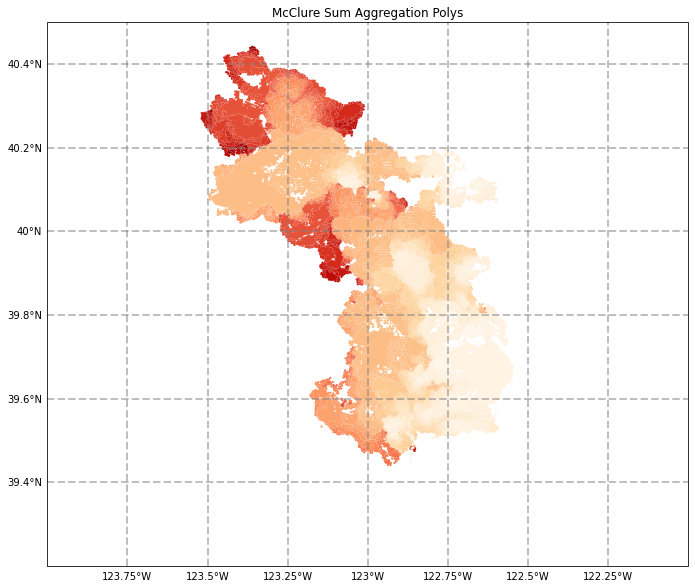

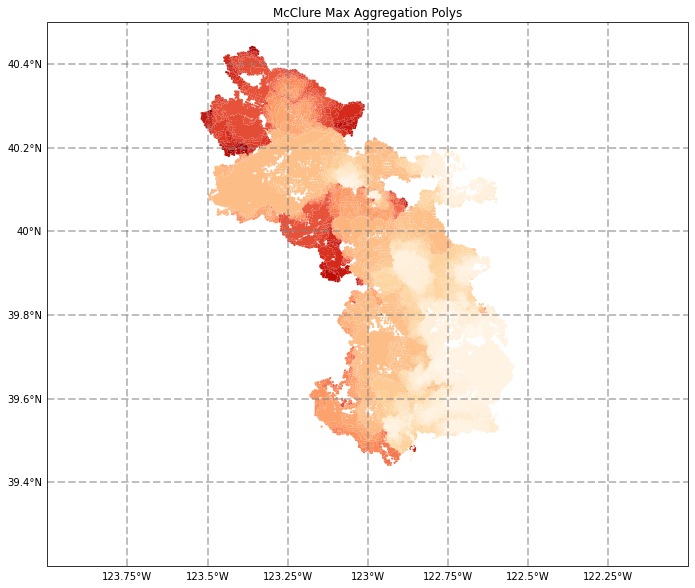

In [15]:
fig = plt.figure(figsize=(15,10))
ax= fig.add_subplot(111,projection=ccrs.PlateCarree())
ax.set_extent([-124, -122, 39.2,40.5])
ac_mcclure_daily_sum.plot(column = ac_mcclure_daily_sum['Days'], ax=ax, cmap='OrRd')
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,\
                  linewidth=2, color='gray', alpha=0.5, linestyle='--')
gl.top_labels = False
gl.right_labels = False
plt.title('McClure Sum Aggregation Polys')
plt.show()

fig = plt.figure(figsize=(15,10))
ax= fig.add_subplot(111,projection=ccrs.PlateCarree())
ax.set_extent([-124, -122, 39.2,40.5])
ac_mcclure_daily_max.plot(column = ac_mcclure_daily_max['Days'], ax=ax, cmap='OrRd')
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,\
                  linewidth=2, color='gray', alpha=0.5, linestyle='--')
gl.top_labels = False
gl.right_labels = False
plt.title('McClure Max Aggregation Polys')
plt.show()

## Make a time series of the RAVE Emissions

In [19]:
#MERRA Time Series

#times = np.arange(np.datetime64('2020-08-17'), np.datetime64('2020-10-18')) #how long we have Crystal's polygons for

times = ac_mcclure_daily_max['Days'].values
print(times)

df_rave_mcclure = pd.DataFrame({'Mean_FRP':np.zeros(len(times)),\
                          'FRE':np.zeros(len(times)),  'CO2':np.zeros(len(times)),  'CO':np.zeros(len(times)),\
                          'SO2':np.zeros(len(times)),  'OC':np.zeros(len(times)),  'BC':np.zeros(len(times)),\
                          'PM2.5':np.zeros(len(times)),  'NOx':np.zeros(len(times)),  'NH3':np.zeros(len(times))})


#loop over times
#loop over variables
# put it all into a dataframe

varis = ['Mean_FRP', 'FRE', 'CO2', 'CO', 'SO2', 'OC', 'BC', 'PM2.5', 'NOx', 'NH3'] #don't need 'area', it's the area of each cell
path_prefix = '/data2/lthapa/2020/Apr2020_to_Oct2020/'
file_prefix = 'Hourly_Emissions_FV3_13km_'

for ii in range(len(times)):
    print(ii)
    date=str(times[ii])
    yr = date[0:4]
    mo = date[5:7]
    dy = date[8:10]
    
    path_rave = path_prefix + file_prefix + yr+mo+dy+'0000_'+yr+mo+dy+'2300.nc'
    dat = nc.Dataset(path_rave) # load in the data
    lat_corner = dat['Latitude'][:] #get the lat/lons
    lon_corner = dat['Longitude'][:]-360 #need to convert to degrees west or negative lon
    lat_center, lon_center = calculate_grid_cell_corners(lat_corner, lon_corner)
    
    print(lat_corner.shape, lat_center.shape)

    mcclure_ind = np.where(ac_mcclure_daily_max['Days']==str(times[ii]))
    #print(mcclure_ind, thapa_ind)
    
    if len(mcclure_ind[0])==0:
        print('No McClure poly!')
        df_rave_mcclure.iloc[ii] = np.nan*np.zeros((1,10)) #nan for this instance
            
    else:
        print(ii, 'McClure Poly Present')
        poly_mcclure = ac_mcclure_daily_max['geometry'].iloc[mcclure_ind[0]]
        overlap_mcclure = calculate_overlaps(lat_center,lon_center,lat_corner,lon_corner,poly_mcclure.iloc[0], 'curvilinear',1)
        overlap_mcclure[np.where(overlap_mcclure!=0)]=1
        # print(np.where(overlap_thapa!=0))
        for var in varis:
            field = np.swapaxes(np.swapaxes(dat[var][:], 0,2), 1,2)
           #print(var,np.sum(feature_hourly(field, overlap_mcclure)),np.sum(feature_hourly(field, overlap_thapa)))
            df_rave_mcclure[var].iloc[ii] = np.sum(feature_hourly(field, overlap_mcclure))
            
df_rave_mcclure

['2020-08-17' '2020-08-18' '2020-08-19' '2020-08-20' '2020-08-21'
 '2020-08-22' '2020-08-23' '2020-08-24' '2020-08-25' '2020-08-26'
 '2020-08-27' '2020-08-28' '2020-08-29' '2020-08-30' '2020-08-31'
 '2020-09-01' '2020-09-02' '2020-09-03' '2020-09-04' '2020-09-05'
 '2020-09-06' '2020-09-07' '2020-09-08' '2020-09-09' '2020-09-10'
 '2020-09-11' '2020-09-12' '2020-09-13' '2020-09-14' '2020-09-15'
 '2020-09-16' '2020-09-17' '2020-09-18' '2020-09-19' '2020-09-20'
 '2020-09-21' '2020-09-22' '2020-09-23' '2020-09-24' '2020-09-25'
 '2020-09-26' '2020-09-27' '2020-09-28' '2020-09-29' '2020-09-30'
 '2020-10-01' '2020-10-02' '2020-10-03' '2020-10-04' '2020-10-05'
 '2020-10-06' '2020-10-07' '2020-10-08' '2020-10-09' '2020-10-11'
 '2020-10-12' '2020-10-13' '2020-10-14' '2020-10-15' '2020-10-16'
 '2020-10-17' '2020-10-18' '2020-10-19' '2020-10-28']
0
(233, 397) (232, 396)
0 McClure Poly Present
-123.79045117639356 38.583861925266305 -121.63883695111186 40.77775015629482
24 42 138 159
1
(233, 397) (23

53
(233, 397) (232, 396)
53 McClure Poly Present
-124.49945954013141 38.87015164810757 -121.87499760607561 41.43502292155728
21 42 141 166
54
(233, 397) (232, 396)
54 McClure Poly Present
-124.0201351317195 39.28279374834976 -122.01995962240603 41.284695358194476
25 41 145 164
55
(233, 397) (232, 396)
55 McClure Poly Present
-124.43648502183008 38.872422211156504 -121.88794394928838 41.28556119555001
21 41 141 165
56
(233, 397) (232, 396)
56 McClure Poly Present
-124.39760919734147 39.18303765096654 -122.06355340242652 41.258542988167605
22 40 144 164
57
(233, 397) (232, 396)
57 McClure Poly Present
-124.5213428029707 39.11334884068783 -122.06312224265653 41.28569050202246
21 40 143 165
58
(233, 397) (232, 396)
58 McClure Poly Present
-124.43174607231187 39.07641413900121 -121.89623405750093 41.441277277789304
22 42 143 166
59
(233, 397) (232, 396)
59 McClure Poly Present
-124.44536998383539 38.97652303991702 -121.89536527196763 41.4436007223171
21 42 142 166
60
(233, 397) (232, 396)
6

,Mean_FRP,FRE,CO2,CO,SO2,OC,BC,PM2.5,NOx,NH3
0,5.675929e+03,2.043334e+07,1.201987e+07,6.662251e+05,5263.629173,8.196222e+04,4135.708711,9.624923e+04,1.436219e+04,6.316355e+03
1,7.460042e+03,2.685615e+07,1.579808e+07,8.756395e+05,6918.144348,1.077254e+05,5435.685295,1.265032e+05,1.887665e+04,8.301773e+03
2,1.123129e+06,4.043263e+09,2.406860e+09,1.235155e+08,966845.654272,1.352917e+07,759896.436680,1.721689e+07,3.488238e+06,1.158916e+06
3,8.734146e+05,3.144293e+09,1.882893e+09,9.278555e+07,722520.495545,9.464211e+06,567966.271329,1.267027e+07,2.966687e+06,8.655037e+05
4,2.842087e+05,1.023151e+09,6.069678e+08,3.186726e+07,250155.619790,3.621370e+06,196592.492222,4.491243e+06,8.351628e+05,2.999536e+05
...,...,...,...,...,...,...,...,...,...,...
59,2.976222e+03,1.071440e+07,6.302725e+06,3.493409e+05,2760.029569,4.297760e+04,2168.594740,5.046911e+04,7.530938e+03,3.312035e+03
60,2.249445e+01,8.098001e+04,4.763633e+04,2.640337e+03,20.860452,3.248270e+02,16.390356,3.814483e+02,5.691923e+01,2.503254e+01
61,1.345164e+02,4.842590e+05,2.848644e+05,1.578917e+04,124.745117,1.942460e+03,98.014025,2.281054e+03,3.403760e+02,1.496941e+02
62,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00


# Helper Functions

In [11]:
def calculate_grid_cell_corners(LAT, LON):
    #we will assume the very edges of the polygons don't touch the boundary of the domain
    lat_corners = (LAT[0:(LAT.shape[0]-1),  0:(LAT.shape[1])-1] + LAT[1:(LAT.shape[0]), 1:(LAT.shape[1])])/2
    lon_corners = (LON[0:(LAT.shape[0]-1),  0:(LAT.shape[1])-1] + LON[1:(LAT.shape[0]), 1:(LAT.shape[1])])/2
    return lat_corners, lon_corners

In [6]:
# this function calculates the overlap between the given shape (fire_shape) and given grid (LAT, LON). 
# buff_search is the buffer for finding overlaps, =1 for everything except NCAR Fuel = 0.05
#grid type should be 'rectilinear' or 'curvilinear'
#LAT and LON should be 2D

def calculate_overlaps(lat, lon, lat_corners, lon_corners, fire_shape, grid_type, buff_search):
    overlaps = np.zeros(lat.shape)
    # buffer the fire shape so it has a non zero area
    if fire_shape.area ==0:
        fire_shape = fire_shape.buffer(0.01)
    fire_shape = fire_shape.buffer(0)
    #print(fire_shape.area)
    #buffer again by 1 degree so we can get the lat start and lat stop
    fire_shape_buff = fire_shape.buffer(buff_search)
    # get the bounds of the buffered polygon
    w,s,e,n = fire_shape_buff.bounds
    print(w,s,e,n)
    if grid_type =='rectilinear':    
        lat_start = np.unique(np.argmin(np.abs(lat-s), axis=0))[0]
        lat_stop = np.unique(np.argmin(np.abs(lat-n), axis=0))[0]
        lon_start = np.unique(np.argmin(np.abs(lon-w), axis=1))[0]
        lon_stop = np.unique(np.argmin(np.abs(lon-e), axis=1))[0]
        #print(lat_start, lat_stop, lon_start, lon_stop)
    elif grid_type=='curvilinear':
        lon_start, lon_stop, lat_start, lat_stop =  bbox2ij(lon, lat, [w, e, s, n])
        
    print(lon_start, lon_stop, lat_start, lat_stop)
    # find the intersection between the first day's polygon and the  grid
    for ii in range(lat_start, lat_stop):
        for jj in range(lon_start, lon_stop):
            #print(lat[ii,jj], lon[ii,jj])
            poly_cell = Polygon([(lon_corners[ii, jj-1],lat_corners[ii, jj-1]),\
                                 (lon_corners[ii, jj],lat_corners[ii, jj]),\
                                 (lon_corners[ii-1, jj],lat_corners[ii-1, jj-1]),\
                                 (lon_corners[ii-1, jj-1], lat_corners[ii-1, jj-1])])
            #THIS SHOWS THE CELLS WE CHECK FOR OVERLAPS
            #fig = plt.figure(figsize=(15,10))
            #ax= fig.add_subplot(111,projection=ccrs.PlateCarree())
            #gpd.GeoSeries(poly_cell).plot(ax=ax)
            #gpd.GeoSeries(fire_shape).plot(ax=ax, color='r', alpha=0.5)
            #plt.xticks()
            #plt.yticks()
            #plt.show()
            overlap_cell = fire_shape.intersection(poly_cell)
            #print(overlap_cell)
            #overlaps are the fraction of the POLYGON in each grid cell
            overlaps[ii,jj] = overlap_cell.area/fire_shape.area
    
    return overlaps

In [7]:
# this function extracts a feature hourly over the polygon for the day
#IN: feat_grid, the 3d grid of the feature. overlaps: the 2d grid of the overlaps. 3d grid needs time as 1st dimension
#OUT: hourly_vec, the hourly time series of the feature over the day for the polygon

def feature_hourly(feat_grid, overlaps): 
    overlaps_stacked = np.repeat(overlaps[:, :, np.newaxis], 24, axis=2) #stack the 2d overlaps into a 3d grid
    overlaps_swapped = np.swapaxes(np.swapaxes(overlaps_stacked, 0,2), 1,2) #make the same shape as the feature grid

    hourly_grid = np.multiply(overlaps_swapped, feat_grid)
    hourly_vec = np.nansum(np.nansum(hourly_grid, axis=1), axis=1)
    
    return hourly_vec

In [8]:
#plots two lines, on one or on the same axis
# IN: datax, x axis vector (time)
# IN: datay, 2*n vector of the data
# IN: linelabels, string vector of the labels of each line, to go in the legend
# IN: axis labels, labels of the axis
# IN: title, string for title of figire
# IN: twoaxis, if 1 plot data on two separate axes, else plot on the same axis
# OUT: a graph
def plot_twoline(datax, datay, title, linelabels, axislabels, twoaxis):
    fig, ax = plt.subplots(figsize=(20,8)) #set up the figure
    
    if twoaxis==1:
        ax.plot(datax, datay[0,:], 'ro-') # plot the first line
        ax.set_ylabel(axislabels[0], fontsize=24, color='red') 
        ax2=ax.twinx()
        ax2.plot(datax, datay[1,:], 'bo-') #plot the second line
        ax2.set_ylabel(axislabels[1], fontsize=24, color='blue')
        
    else:
        ax.plot(datax, datay[0,:], 'ro-') # plot the first line
        ax.plot(datax, datay[1,:], 'bo-') # plot the second line
        ax.set_ylabel(axislabels, fontsize=24) 
    
        
    plt.legend(linelabels,fontsize=24)
    plt.title(title,fontsize=24)
    plt.grid()
    plt.show()



In [17]:
#fnction is from here: https://gis.stackexchange.com/questions/71630/subsetting-a-curvilinear-netcdf-file-roms-model-output-using-a-lon-lat-boundin
def bbox2ij(lon,lat,bbox):
    bbox=np.array(bbox)
    mypath=np.array([bbox[[0,1,1,0]],bbox[[2,2,3,3]]]).T
    p = path.Path(mypath)
    points = np.vstack((lon.flatten(),lat.flatten())).T
    n,m = np.shape(lon)
    inside = p.contains_points(points).reshape((n,m))
    ii,jj = np.meshgrid(range(m),range(n)) #ii is the columns, jj is the rows
    return min(ii[inside]),max(ii[inside]),min(jj[inside]),max(jj[inside])